# python机器学习实战（二）

## 前言

这篇notebook是关于机器学习中监督学习的决策树算法，内容包括决策树算法的构造过程，使用matplotlib库绘制树形图以及使用决策树预测隐形眼睛类型. 
                   操作系统：ubuntu14.04   运行环境：anaconda-python2.7-jupyter notebook    参考书籍：机器学习实战和源码            notebook writer ----方阳 

决策树原理：不断通过数据集的特征来划分数据集，直到遍历所有划分数据集的属性，或每个分支下的实例都具有相同的分类，决策树算法才停止运行。

决策树的优缺点及适用类型
优点 :计算复杂度不高, 输出结果易于理解,对中间值的缺失不敏感,可以处理不相关特征数据。
缺点 :可能会产生过度匹配问题。
适用数据类型:数值型和标称型

先举一个小例子，让你了解决策树是干嘛的，简单来说，决策树算法就是一种基于特征的分类器，拿邮件来说吧，试想一下，邮件的类型有很多种，有需要及时处理的邮件，无聊是观看的邮件，垃圾邮件等等，我们需要去区分这些，比如根据邮件中出现里你的名字还有你朋友的名字，这些特征就会就可以将邮件分成两类，需要及时处理的邮件和其他邮件，这时候在分类其他邮件，例如邮件中出现buy，money等特征，说明这是垃圾推广文件，又可以将其他文件分成无聊是观看的邮件和垃圾邮件了。

## 1.决策树的构造

### 1.1 信息增益

试想一下，一个数据集是有多个特征的，我们该从那个特征开始划分呢，什么样的划分方式会是最好的？

我们知道划分数据集的大原则是将无序的数据变得更加有序，这样才能分类得更加清楚，这里就提出了一种概念，叫做信息增益，它的定义是在划分数据集之前之后信息发生的变化，变化越大，证明划分得越好，所以在划分数据集的时候，获得增益最高的特征就是最好的选择。

这里又会扯到另一个概念，信息论中的熵，它是集合信息的度量方式，熵变化越大，信息增益也就越大。信息增益是熵的减少或者是数据无序度的减少.

一个符号x在信息论中的信息定义是 l(x)= -log(p(x)) ,这里都是以2为底，不再复述。

则熵的计算公式是   H = 

下面开始实现给定数据集，计算熵

参考代码：

In [7]:
from math import log         #we use log function to calculate the entropy
import operator

In [1]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #the the number of unique elements and their occurance
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2)     #log base 2
    return shannonEnt

程序思路：
首先计算数据集中实例的总数,由于代码中多次用到这个值,为了提高代码效率,我们显式地声明一个变量保存实例总数.
然后 ,创建一个数据字典labelCounts,它的键值是最后一列（分类的结果）的数值.如果当前键值不存在,则扩展字典并将当前键值加入字典。每个键值都记录了当前类别出现的次数。
最后 , 使用所有类标签的发生频率计算类别出现的概率。我们将用这个概率计算香农熵

让我们来测试一下，先自己定义一个数据集

下表的数据包含 5 个海洋动物,特征包括:不浮出水面是否可以生存,以及是否有脚蹼。我们可以将这些动物分成两类: 鱼类和非鱼类。

                                                                                            海洋生物数据
                              不浮出水面是否可以生存                        是否有脚撲                                               属于鱼类
1                                             是                                                 是                                                           是
2                                             是                                                 是                                                           是
3                                             是                                                 否                                                           否
4                                             否                                                 是                                                           否
5                                             否                                                 是                                                           否 

根据上面的表格，我们可以定义一个createDataSet函数

参考代码如下

In [2]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    #change to discrete values
    return dataSet, labels

把所有的代码都放在trees.py中

In [1]:
cd /home/fangyang/桌面/machinelearninginaction/Ch03

/home/fangyang/桌面/machinelearninginaction/Ch03


In [7]:
import trees

In [36]:
myDat, labels = trees.createDataSet()

In [10]:
myDat  #old data set

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [11]:
labels 

['no surfacing', 'flippers']

In [12]:
trees.calcShannonEnt(myDat)  #calculate  the  entropy

0.9709505944546686

In [13]:
myDat[0][-1]='maybe'     #change the result ,and look again the entropy 

In [14]:
myDat  #new data set

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [15]:
trees.calcShannonEnt(myDat)   # the new entropy

1.3709505944546687

我们可以看到当结果分类改变，熵也发生里变化，主要是因为最后的结果发生里改变，相应的概率也发生了改变，根据公式，熵也会改变

### 1.2  划分数据集

前面已经得到了如何去求信息熵的函数，但我们的划分是以哪个特征划分的呢，不知道，所以我们还要写一个以给定特征划分数据集的函数。

参考代码如下：

In [16]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     #chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

函数的三个输人参数:待划分的数据集（dataSet）、划分数据集的特征（axis）、特征的返回值（value）。输出是划分后的数据集（retDataSet）

小知识：python语言在函数中传递的是列表的引用 ,在函数内部对列表对象的修改, 将会影响该列表对象的整个生存周期。为了消除这个不良影响 ,我们需要在函数的开始声明一个新列表对象。 因为该函数代码在同一数据集上被调用多次,为了不修改原始数据集,创建一个新的列表对象retDataSet

这个函数也挺简单的，根据axis的值所指的对象来进行划分数据集，比如axis=0，就按照第一个特征来划分，featVec[:axis]就是空,下面经过一个extend函数，将featVec[axis+1:]后面的数存到reduceFeatVec中，然后通过append函数以列表的形式存到retDataSet中。

这里说一下entend和append函数的功能，举个例子吧

In [17]:
a=[1,2,3]

In [18]:
b=[4,5,6]

In [19]:
a.append(b)

In [20]:
a

[1, 2, 3, [4, 5, 6]]

In [21]:
a=[1,2,3]

In [22]:
a.extend(b)

In [23]:
a

[1, 2, 3, 4, 5, 6]

可见append函数是直接将b的原型导入a中，extend是将b中的元素导入到a中

下面再来测试一下

In [24]:
myDat, labels = trees.createDataSet()  #initialization

In [25]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [26]:
trees.splitDataSet(myDat,0,1)  #choose the first character to split the dataset

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [27]:
trees.splitDataSet(myDat,0,0)# change the value ,look  the difference  of  previous results

[[1, 'no'], [1, 'no']]

好了，我们知道了怎样以某个特征划分数据集了，但我们需要的是最好的数据集划分方式，所以要结合前面两个函数，计算以每个特征为划分方式，相应最后的信息熵，我们要找到最大信息熵，它所对应的特征就是我们要找的最好划分方式。所以有了函数chooseBestFeatureToSpilt

参考代码如下：

In [28]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels
    baseEntropy = calcShannonEnt(dataSet) #calculate the original entropy 
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):        #iterate over all the features
        featList = [example[i] for example in dataSet]#create a list of all the examples of this feature
        uniqueVals = set(featList)       #get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)     
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy
        if (infoGain > bestInfoGain):       #compare this to the best gain so far
            bestInfoGain = infoGain         #if better than current best, set to best
            bestFeature = i
    return bestFeature                      #returns an integer

这个函数就是把前面两个函数整合起来了，先算出特征的数目，由于最后一个是标签，不算特征，所以以数据集长度来求特征数时，要减1。然后求原始的信息熵，是为了跟新的信息熵，进行比较，选出变化最大所对应的特征。这里有一个双重循环，外循环是按特征标号进行循环的，下标从小到大，featList是特征标号对应下的每个样本的值，是一个列表，而uniqueVals是基于这个特征的所有可能的值的集合，内循环做的是以特征集合中的每一个元素作为划分，最后求得这个特征下的平均信息熵，然后原始的信息熵进行比较，得出信息增益，最后的if语句是要找到最大信息增益，并得到最大信息增益所对应的特征的标号。

现在来测试测试

In [4]:
import trees

In [5]:
myDat, labels = trees.createDataSet()

In [6]:
trees.chooseBestFeatureToSplit(myDat)   #return the index of best character to split

0

### 1.3 递归构建决策树

好了，到现在，我们已经知道如何基于最好的属性值去划分数据集了，现在进行下一步，如何去构造决策树

决策树的实现原理：得到原始数据集, 然后基于最好的属性值划分数据集,由于特征值可能多于两个,因此可能存在大于两个分支的数据集划分。第一次划分之后, 数据将被向下传递到树分支的下一个节点, 在这个节点上 ,我们可以再次划分数据。因此我们可以采用递归的原则处理数据集。

递归结束的条件是:程序遍历完所有划分数据集的属性, 或者每个分支下的所有实例都具有相同的分类。

这里先构造一个majorityCnt函数，它的作用是返回出现次数最多的分类名称，后面会用到

In [8]:
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

这个函数在实战一中的一个函数是一样的，复述一遍，classCount定义为存储字典，每当，由于后面加了1，所以每次出现键值就加1，就可以就算出键值出现的次数里。最后通过sorted函数将classCount字典分解为列表，sorted函数的第二个参数导入了运算符模块的itemgetter方法，按照第二个元素的次序（即数字）进行排序，由于此处reverse=True，是逆序，所以按照从大到小的次序排列。

让我们来测试一下

In [15]:
import numpy as np
classList = np.array(myDat).T[-1]

In [16]:
classList

array(['yes', 'yes', 'no', 'no', 'no'], 
      dtype='|S21')

In [17]:
majorityCnt(classList)    #the number of 'no' is 3, 'yes' is 2,so return 'no'

'no'

接下来是创建决策树函数

代码如下：

In [18]:
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList): 
        return classList[0]#stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])              #delete the best feature , so it can find the next best feature
    featValues = [example[bestFeat] for example in dataSet] 
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree  

前面两个if语句是判断分类是否结束，当所有的类都相等时，也就是属于同一类时，结束再分类，又或特征全部已经分类完成了，只剩下最后的class，也结束分类。这是判断递归结束的两个条件。一般开始的时候是不会运行这两步的，先选最好的特征，使用 chooseBestFeatureToSplit函数得到最好的特征，然后进行分类，这里创建了一个大字典myTree，它将决策树的整个架构全包含进去,这个等会在测试的时候说，然后对数据集进行划分，用splitDataSet函数，就可以得到划分后新的数据集，然后再进行createTrees函数，直到递归结束。

来测试一下

In [23]:
myTree = trees.createTree(myDat,labels)

In [24]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

再来说说上面没详细说明的大字典，myTree是特征是‘no surfacing’,根据这个分类，得到两个分支‘0’和‘1‘，‘0’分支由于全是同一类就递归结束里，‘1’分支不满足递归结束条件，继续进行分类，它又会生成它自己的字典，又会分成两个分支，并且这两个分支满足递归结束的条件，所以返回‘no surfacing’上的‘1’分支是一个字典。这种嵌套的字典正是决策树算法的结果，我们可以使用它和Matplotlib来进行画决策树。

以上是决策树算法的整个过程，到此结束。

### 1.4 使用决策树执行分类

这个就是将测试合成一个函数，定义为classify函数

参考代码如下：

In [25]:
def classify(inputTree,featLabels,testVec):
    firstStr = inputTree.keys()[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): 
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

这个函数就是一个根据决策树来判断新的测试向量是那种类型，这也是一个递归函数，拿上面决策树的结果来说吧。

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}，这是就是我们的inputTree，首先通过函数的第一句话得到它的第一个bestFeat，也就是‘no surfacing’，赋给了firstStr，secondDict就是‘no surfacing’的值，也就是 {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}，然后用index函数找到firstStr的标号，结果应该是0，根据下标，把测试向量的值赋给key，然后找到对应secondDict中的值，这里有一个isinstance函数，功能是第一个参数的类型等于后面参数的类型，则返回true，否则返回false，testVec列表第一位是1，则valueOfFeat的值是 {0: 'no', 1: 'yes'}，是dict，则递归调用这个函数，再进行classify，知道不是字典，也就最后的结果了，其实就是将决策树过一遍，找到对应的labels罢了。

这里有一个小知识点，在jupyter notebook中，显示绿色的函数，可以通过下面查询它的功能，例如

In [ ]:
isinstance?     #run it , you will see a below window which is used to introduce this function

让我们来测试测试

In [43]:
trees.classify(myTree,labels,[1,0])

'no'

In [44]:
trees.classify(myTree,labels,[1,1])

'yes'

### 1.5 决策树的存储

构造决策树是很耗时的任务,即使处理很小的数据集, 如前面的样本数据, 也要花费几秒的时间 ,如果数据集很大,将会耗费很多计算时间。然而用创建好的决策树解决分类问题，可以很快完成。因此 ,为了节省计算时间,最好能够在每次执行分类时调用巳经构造好的决策树。

解决方案：使用pickle模块存储决策树

参考代码：

In [45]:
def storeTree(inputTree,filename):
    import pickle
    fw = open(filename,'w')
    pickle.dump(inputTree,fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    fr = open(filename)
    return pickle.load(fr)

就是将决策树写到文件中，用的时候在取出来，测试一下就明白了

In [46]:
trees.storeTree(myTree,'classifierStorage.txt')   #run it ,store the tree

In [47]:
trees.grabTree('classifierStorage.txt')  

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

决策树的构造部分结束了，下面介绍怎样绘制决策树

## 2.  使用Matplotlib注解绘制树形图

前面我们看到决策树最后输出是一个大字典，非常丑陋，我们想让它更有层次感，更加清晰，最好是图形状的，于是，我们要Matplotlib去画决策树。

### 2.1 Matplotlib注解

Matplotlib提供了一个注解工具annotations,它可以在数据图形上添加文本注释。

创建一个treePlotter.py文件来存储画图的相关函数

首先是使用文本注解绘制树节点，参考代码如下：

In [50]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',\
             xytext=centerPt, textcoords='axes fraction',\
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def createPlot1():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

前面三行是定义文本框和箭头格式，decisionNode是锯齿形方框，文本框的大小是0.8，leafNode是4边环绕型，跟矩形类似，大小也是4，arrow_args是指箭头，我们在后面结果是会看到这些东西，这些数据以字典类型存储。第一个plotNode函数的功能是绘制带箭头的注解，输入参数分别是文本框的内容，文本框的中心坐标，父结点坐标和文本框的类型，这些都是通过一个createPlot.ax1.annotate函数实现的，create.ax1是一个全局变量，这个函数不多将，会用就行了。第二个函数createPlot就是生出图形，也没什么东西，函数第一行是生成图像的画框，横纵坐标最大值都是1，颜色是白色，下一个是清屏，下一个就是分图，111中第一个1是行数，第二个是列数，第三个是第几个图，这里就一个图，跟matlab中的一样，matplotlib里面的函数都是和matlab差不多。

来测试以下吧

In [1]:
reset -f   #clear all the module and data

In [4]:
cd 桌面/machinelearninginaction/Ch03

/home/fangyang/桌面/machinelearninginaction/Ch03


In [5]:
import treePlotter
import matplotlib.pyplot as plt

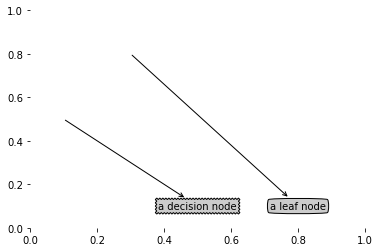

In [6]:
treePlotter.createPlot1()

### 2.2 构造注解树

参考代码：

In [9]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

我们可以看到两个方法有点似曾相识，没错，我们在进行决策树分类测试时，用的跟这个几乎一样，分类测试中的isinstance函数换了一种方式去判断，递归依然在，不过是每递归依次，高度增加1，叶子数同样是检测是否为字典，不是字典则增加相应的分支。

这里还写了一个函数retrieveTree，它的作用是预先存储的树信息,避免了每次测试代码时都要从数据中创建树的麻烦

参考代码如下

In [1]:
def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

这个没什么好说的，就是把决策树的结果存在一个函数中，方便调用，跟前面的存储决策树差不多。

有了前面这些基础后，我们就可以来画树了。

参考代码如下：

In [2]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = myTree.keys()[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

第一个函数是在父子节点中填充文本信息，函数中是将父子节点的横纵坐标相加除以2，上面写得有一点点不一样，但原理是一样的，然后还是在这个中间坐标的基础上添加文本，还是用的是 createPlot.ax1这个全局变量，使用它的成员函数text来添加文本，里面是它的一些参数。

第二个函数是关键，它调用前面我们说过的函数，用树的宽度用于计算放置判断节点的位置 ,主要的计算原则是将它放在所有叶子节点的中间,而不仅仅是它子节点的中间，根据高度就可以平分坐标系了，用坐标系的最大值除以高度，就是每层的高度。这个plotTree函数也是个递归函数，每次都是调用，画出一层，知道所有的分支都不是字典后，才算画完。每次检测出是叶子，就记录下它的坐标，并写出叶子的信息和父子节点间的信息。plotTree.xOff和plotTree.yOff是用来追踪已经绘制的节点位置，以及放置下一个节点的恰当位置。

第三个函数我们之前介绍介绍过一个类似，这个函数调用了plotTree函数，最后输出树状图，这里只说两点，一点是全局变量plotTree.totalW存储树的宽度 ,全
局变量plotTree.totalD存储树的深度，还有一点是plotTree.xOff和plotTree.yOff是在这个函数这里初始化的。

最后我们来测试一下

In [5]:
cd 桌面/machinelearninginaction/Ch03

/home/fangyang/桌面/machinelearninginaction/Ch03


In [6]:
import treePlotter

In [7]:
myTree = treePlotter.retrieveTree(0)

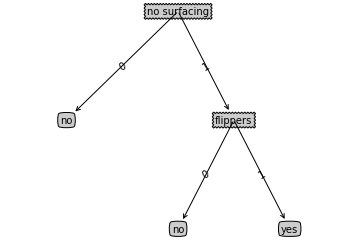

In [8]:
treePlotter.createPlot(myTree)

改变标签，重新绘制图形

In [9]:
myTree['no surfacing'][3] = 'maybe'

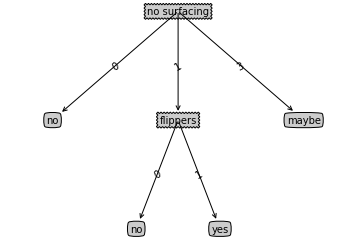

In [10]:
treePlotter.createPlot(myTree)

至此，用matplotlib画决策树到此结束。

## 3 使用决策树预测眼睛类型

隐形眼镜数据集是非常著名的数据集 , 它包含很多患者眼部状况的观察条件以及医生推荐的隐形眼镜类型 。隐形眼镜类型包括硬材质 、软材质以及不适合佩戴 隐形眼镜 。数据来源于UCI数据库 ,为了更容易显示数据 , 将数据存储在源代码下载路径的文本文件中。

进行测试

In [11]:
fr = open('lenses.txt')

In [12]:
lenses = [inst.strip().split('\t') for inst in fr.readlines()]

In [13]:
lensesLabels = ['age' , 'prescript' , 'astigmatic','tearRate']

In [14]:
import trees
lensesTree = trees.createTree(lenses,lensesLabels)

In [15]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

这样看，非常乱，看不出什么名堂，画出决策树树状图看看

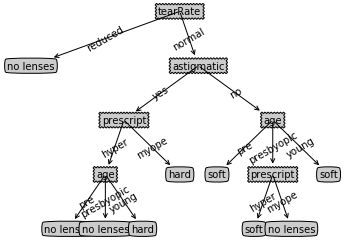

In [16]:
treePlotter.createPlot(lensesTree)

这就非常清楚了

## 结尾

这篇notebook写了两天多，接近三天，好累，希望这篇关于决策树的博客能够帮助到你，如果发现错误，还望不吝指教，谢谢！

觉得不错的，赐我金笔吧，哈哈，我需要鼓励鼓励，(*^__^*) 嘻嘻……